
# Decision Trees on Spark

Let's setup Spark Colab environment.

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Now I am authenticate a Google Drive client to download the files that I will be processing in Spark job.

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1aJrdYMVmmnUKYhLTlXtyB0FQ9gYJqCrs'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mnist-digits-train.txt')

id='1yLwxRaJIyrC03yxqbTKpedMmHEF86AAq'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mnist-digits-test.txt')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, let me import some of the common libraries needed for my task.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [6]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [7]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-10-05 10:56:17--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.19M  12.8MB/s    in 1.0s    

2021-10-05 10:56:18 (12.8 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ngrok                   
http://cd7c-35-204-80-15.ngrok.io


### Data Loading

![MNIST](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png)

I will be using the famous [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), a large collection of handwritten digits that is widely used for training and testing in the field of machine learning.

The dataset has already been converted to the popular LibSVM format, where each digit is represented as a sparse vector of grayscale pixel values.

In [8]:
training = spark.read.format("libsvm").load("mnist-digits-train.txt")
test = spark.read.format("libsvm").load("mnist-digits-test.txt")

# Cache data for multiple uses
training.cache()
test.cache()

DataFrame[label: double, features: vector]

In [9]:
training.show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
training.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [11]:
test.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



First of all, find out how many instances we have in our training / test split.

In [12]:
print(training.count())
print(test.count())

60000
10000


Now train a Decision Tree on the training dataset using Spark MLlib.

I am using the Python example on this documentation page: [https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

In [13]:
# importing the Decision Tree Classifier libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# defining DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Model fitted by DecisionTreeClassifier.
model = dt.fit(training)

predictions = model.transform(test)

With the Decision Tree I just induced on the training data, predict the labels of the test set.
Printing the predictions for the first 10 digits, and comparing them with the labels.

In [14]:
predictions.select("prediction", "label").show(10)

+----------+-----+
|prediction|label|
+----------+-----+
|       7.0|  7.0|
|       2.0|  2.0|
|       8.0|  1.0|
|       0.0|  0.0|
|       9.0|  4.0|
|       1.0|  1.0|
|       5.0|  4.0|
|       6.0|  9.0|
|       6.0|  5.0|
|       9.0|  9.0|
+----------+-----+
only showing top 10 rows



The small sample above looks good, but not great!

Let's dig deeper. Computing the accuracy of the model, using the ```MulticlassClassificationEvaluator``` from MLlib.

In [15]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % accuracy)


Accuracy = 0.6795 


Finding out the max depth of the trained Decision Tree, and its total number of nodes.

In [16]:
print(model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ad6f4018c453, depth=5, numNodes=61, numClasses=10, numFeatures=780


It appears that the default settings of the Decision Tree implemented in MLlib did not allow us to train a very powerful model!

Before starting to train a Decision Tree, I can tune the max depth it can reach by using the [setMaxDepth()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html#pyspark.ml.classification.DecisionTreeClassifier.setMaxDepth) method. Train 21 different DTs, varying the max depth from 0 to 20, endpoints included (i.e., [0, 20]). For each value of the parameter, I am going to print the accuracy achieved on the test set, and the number of nodes contained in the given DT.

**IMPORTANT:** this parameter sweep can take 30 minutes or more, depending on how busy is your Colab instance. Notice how the induction time grows super-linearly!

In [17]:
def train_dt(training, test, max_depth):
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=max_depth)
    model = dt.fit(training)
    predictions = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    return accuracy

accs = []
for d in range(21):
    accs.append(train_dt(training, test, d))


Just making some changes to plot the Accuracy of the model

In [20]:
y = accs
x = range(0,21)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
y =pd.Series(y)

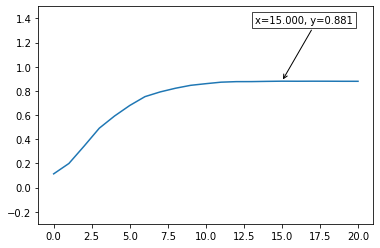

In [21]:
fig, ax = plt.subplots()
ax.plot(x,y)

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,y)


ax.set_ylim(-0.3,1.5)
plt.show()

In [28]:
# Stopping Spark Environment
sc.stop()

It appears that the model is performing 88% accuracy at Max_Depth of 16. Actually, not bad :D